In [119]:
import sys
print(sys.version)

3.6.9 |Anaconda custom (64-bit)| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [120]:
"""
Created on Mar 3 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [122]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [123]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [124]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)

1.17.4
0.15.0
1.3.1


## unit test 

In [126]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28b
npix_value:1280
Science image shape is: (50, 50)
Top left pixel value of the science image is: 1.0
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (50, 50)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [   24.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hs

In [127]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

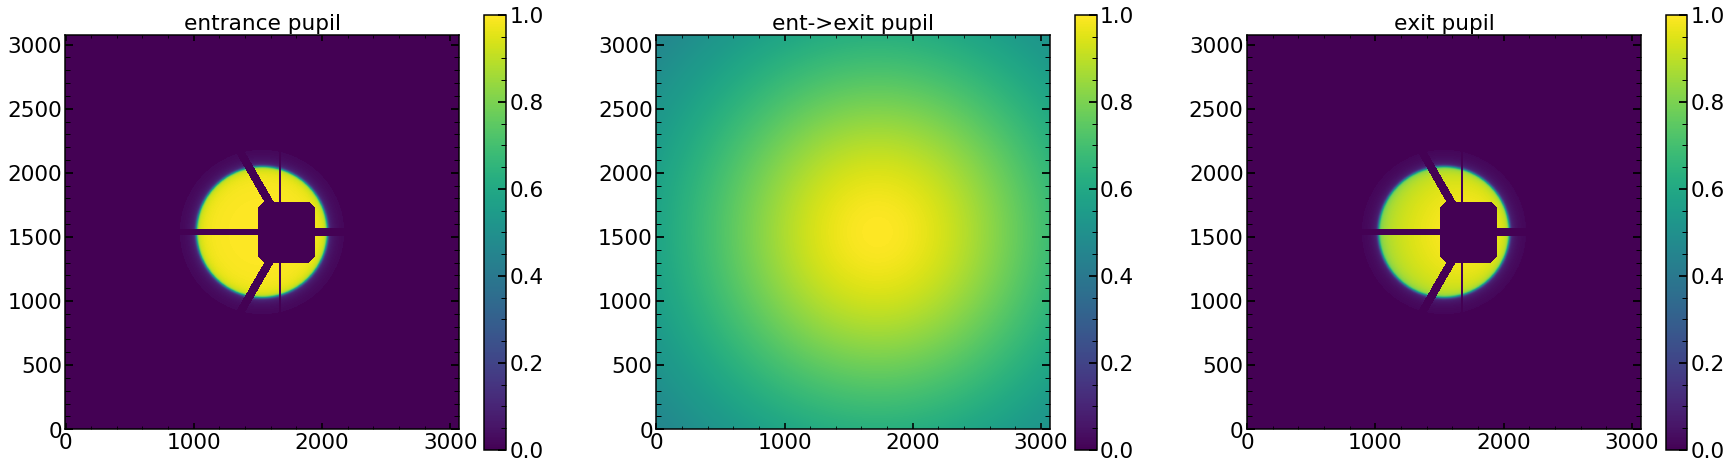

In [128]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

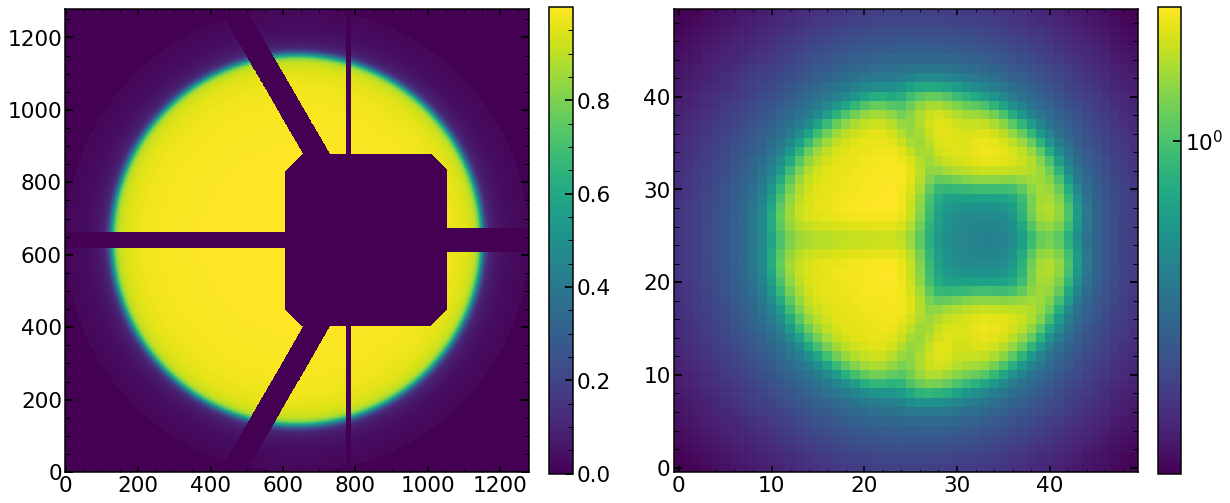

In [129]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([1,10**-2,10**-3,10**-4,10**-5,10,10**2,10**3,10**4,10**5])

# Custom size of ilum_radiometric 

## simulations

In [25]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,simulation_00=1)   
res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28
npix_value:512
Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscF

In [ ]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

In [ ]:
plt.imshow(optPsf_cut_fiber_convolved_downsampled)

In [32]:
# compare results from 50x50 image and 20x20 image - both on real data and when sim00=1

28.95

In [56]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,npix=1536,verbosity=1,sim)   
res=model(allparameters_proposal,return_Image=True)
optPsf_cut_fiber_convolved_downsampled_1536=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1)   
res=model(allparameters_proposal,return_Image=True)
optPsf_cut_fiber_convolved_downsampled_20=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscFrac', 'strutFrac', 'dxFocal', 'dyFocal', 'sl

Time for cutting out the square is 0.14879894256591797
Finished with getPupil
Finished with _get_Pupil
 
Time for single pupil calculation is 0.4267399311065674
Supplied pupil size is (pupil.size) [m]: 0.1395327
One pixel has size of (pupil.scale) [m]: 0.00013626240234375
Supplied pupil has so many pixels (pupil_plane_im): (1024, 1024)
Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 0.0, 0.09, 0.02, -0.1, 0.0, 0.1, 0.02, 0.2]
aberrations 0 [0.0, 0.0, 0.0, 0.0, 0, 0.09, 0.02, -0.1, 0.0, 0.1, 0.02, 0]
aberrations extra: None
self.wavelength: 794
lower_limit_of_ilum: 512
higher_limit_of_ilum: 1536
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (2048, 2048)
size_of_ilum_in_units_of_radius: 2.0
Time for FFT is 0.1808640956878662
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (2048, 2048)
oversampling_original: 35.374287997579025
size_of_central_cut: 990
optPsf_cut.shape(991, 

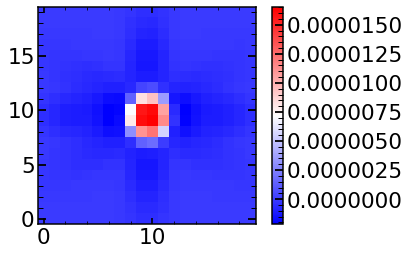

In [64]:
optPsf_cut_fiber_convolved_downsampled_1536=optPsf_cut_fiber_convolved_downsampled_1536*np.sum(1)/np.sum(optPsf_cut_fiber_convolved_downsampled_1536)
optPsf_cut_fiber_convolved_downsampled_20=optPsf_cut_fiber_convolved_downsampled_20/np.sum(optPsf_cut_fiber_convolved_downsampled_20)

plt.imshow(optPsf_cut_fiber_convolved_downsampled_20-optPsf_cut_fiber_convolved_downsampled_1536,cmap='bwr')
plt.colorbar()

## checking with the real data 

### ``old'' version

In [26]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [27]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [30]:

date='Feb1420'
obs=21346+54
obs_int=int(obs)
single_number='57'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]
double_sources=0
double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
double_sources_positions_ratios

0d


array([0, 0], dtype=object)

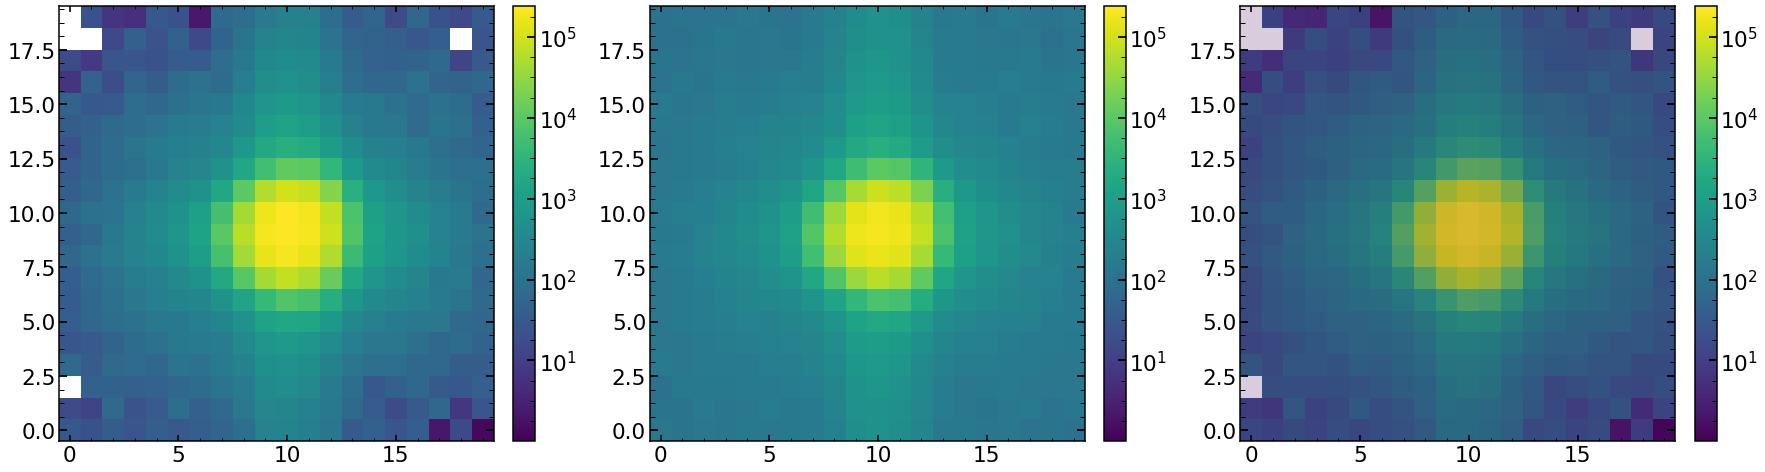

In [31]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [32]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 5380.929438215129
minimal chi2 reduced is: 19.06665524771627


In [409]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (60, 60)
Top left pixel value of the science image is: 338.15002
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 381.6772
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [   30.31229776    -0.42182597    -0.43528261     0.47914274
     0.13289489    -0.07654536    -0.35385487    -0.35668121
    -0.10561782    -0.05251076    -0.0393296     -0.01454286
    -0.0162427      0.02052808     0.0084521      0.01574609
    -0.02253111     0.03012259     0.04264008     0.67491073
     0.08982254    -0.11321028    -0.02234861     0.05591473
     0.03427195     0.00001378     0.00001378     0.97544756
     0.94834567     0.00664462    -0.05191504     0.91502452
     0.05903107     0.68305317     1.00839089  

-1138770.6292106241

In [410]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')

chi**2 reduced is: 621.7611801272317
Abs of residual divided by total flux is: 0.054733871698216446
Abs of residual divided by largest value of a flux in the image is: 0.1384532868513637


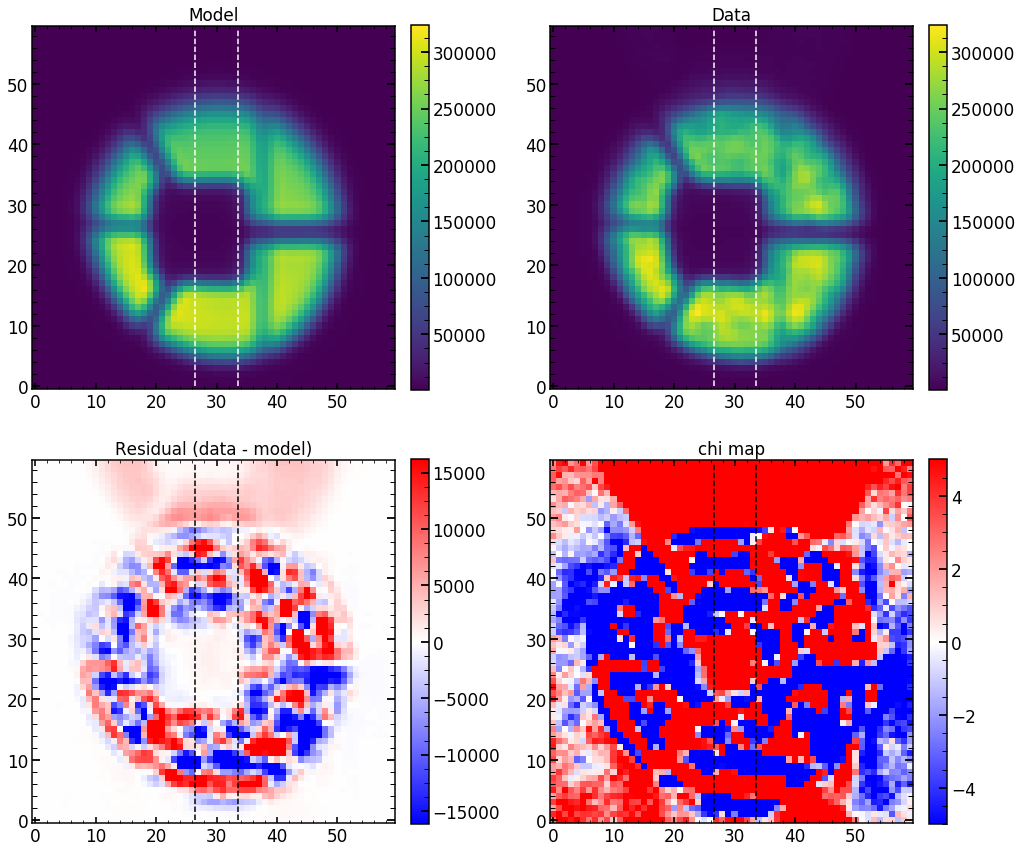

In [411]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

### ``new'' version

In [39]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: 30.257544
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 135.49706
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.19806336    -0.24694844    -0.13653308     0.39085092
    -0.01095516     0.05506952    -0.50631035    -0.26016694
     0.02678486     0.11240715    -0.04227812     0.13926078
    -0.06559608     0.01425848     0.03857009     0.11374348
    -0.07798599     0.10679211     0.23054775     0.7432363
     0.08906604    -0.29028661     0.1593336      0.05469169
     0.04195337     0.0000059      0.0000059      0.97421296
     0.94834465     0.09896747    -0.03767091     0.89762369
     0.0115111      0.74360877     1.04190588  

-5330.566668651544

In [40]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')

chi**2 reduced is: 18.814841178459943
Abs of residual divided by total flux is: 0.03605289630490884
Abs of residual divided by largest value of a flux in the image is: 0.07312789163912978


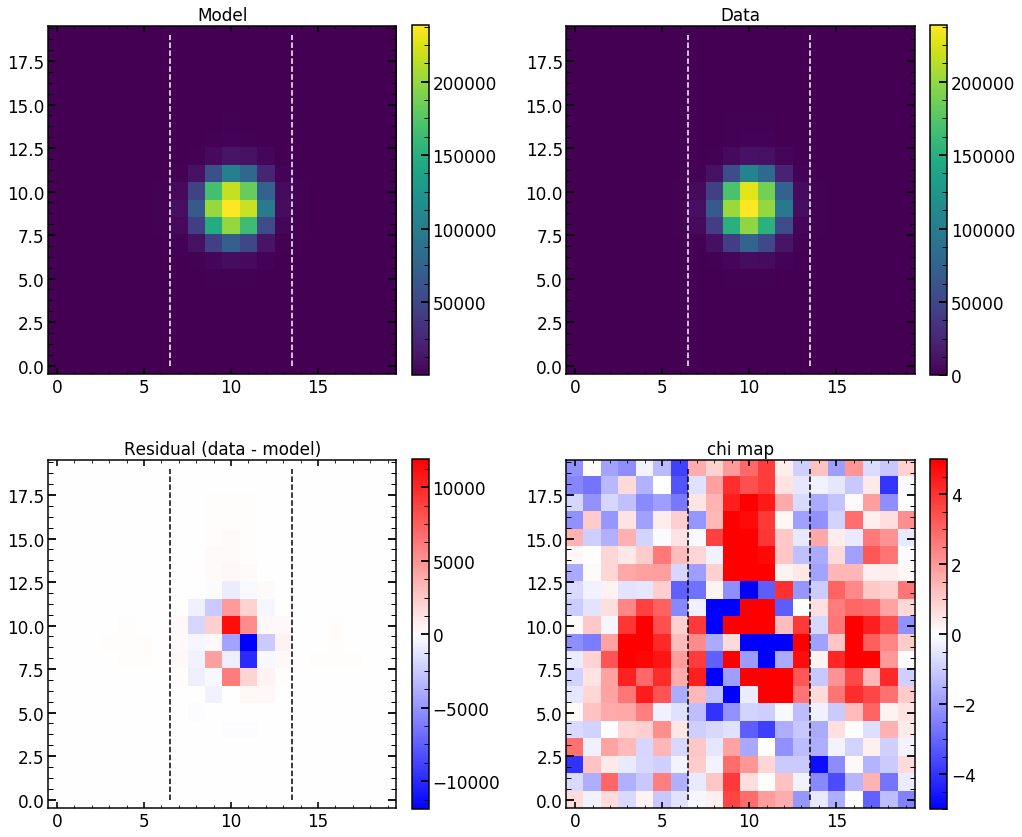

In [41]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

# Mar06

## First test few scripts 

In [27]:
def remove(string): 
    return string.replace(" ", "")

remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))

NameError: name 'finalHgAr_Feb2020_dataset' is not defined

In [66]:
#MPI

list_of_HgAr_to_analyze=[51,53,54,55,56]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48,21346+60,21346+18,21346+90,21346+36,21346+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger01'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T01S'+str(single_spot)+'Mar20.sh \n')

file.close()
##################
##################
##################


list_of_Ne_to_analyze=[26,29]

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+6,21550+102,21550+54,21550+12,21550+96,21550+48,21550+60,21550+18,21550+90,21550+36,21550+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger02'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T02S'+str(single_spot)+'Mar20.sh \n')

file.close()
##################
##################
##################

list_of_Kr_to_analyze=[27,28]

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+96,21754+48,21754+60,21754+18,21754+90,21754+36,21754+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger03'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T03S'+str(single_spot)+'Mar20.sh \n')

file.close()

## extend 

In [28]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [30]:
def remove(string): 
    return string.replace(" ", "")

In [31]:
list_of_HgAr_to_analyze=np.unique(arranged_by_spot_number_HgAr[:,1])
list_of_HgAr_to_analyze

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70])

In [39]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==str(1)].index

Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')

In [355]:
#MPI

list_of_HgAr_to_analyze=[64,65,66,67,68,69,70]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger01'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T01S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15,p15
    for obs in [21346+60,21346+18,21346+90,21346+36,21346+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger02'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T02S'+str(single_spot)+'Mar20.sh \n')

file.close()


##################
##################
##################


list_of_Ne_to_analyze=[ 0,  3,  8,  9, 12, 17, 18, 21, 27, 30, 36, 39, 44, 45, 48, 53, 54,
       57, 62, 63, 66, 71, 72, 75, 80, 81, 84, 89,2, 5,  6,  7, 11, 14, 15, 16, 20, 23, 24, 25, 29, 32, 33, 34, 38,
            41, 42, 43, 47, 50, 51, 52, 56, 59, 60, 61, 65, 68, 69, 70, 74, 77,
            78, 79, 83, 86, 87, 88]

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+60,21550+18,21550+90,21550+36,21550+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()   
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger03'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T03S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T04S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+6,21550+102,21550+54,21550+12,21550+96,21550+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()   
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger04'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T04S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

list_of_Kr_to_analyze=[15,16,17,18,19,20,21]

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T05S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+96,21754+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger05'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T05S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+60,21754+18,21754+90,21754+36,21754+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger06'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T06S'+str(single_spot)+'Mar20.sh \n')

file.close()


## extended Mar 21 - HgAr

In [40]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [41]:
def remove(string): 
    return string.replace(" ", "")

In [42]:
list_of_HgAr_to_analyze=np.unique(arranged_by_spot_number_HgAr[:,1])
list_of_HgAr_to_analyze

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70])

In [43]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==str(1)].index

Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')

In [44]:
#MPI

list_of_HgAr_to_analyze=[ 1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T10S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, m05
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger10'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T10S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T11S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15
    for obs in [21346+60,21346+18,21346+90,21346+36]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger11'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T11S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T12S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # !repetition!
    #  m4, p4, p15, m25, p25
    for obs in [21346+6,21346+102,21346+72,21550+24,21550+84]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger12'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T12S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

## extension - Krypton March 26

In [102]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [103]:
def remove(string): 
    return string.replace(" ", "")

In [105]:
already_Kr_analyzed=np.unique(arranged_by_spot_number_Kr[:,1])
already_Kr_analyzed

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [110]:
finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['close']==0].index

Int64Index([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 16, 17, 18, 20, 21,
            22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37, 38],
           dtype='int64')

In [113]:
list_of_Kr_to_analyze=np.setdiff1d(finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['close']==0].index,already_Kr_analyzed)
list_of_Kr_to_analyze

array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 29, 30, 32, 33, 34,
       36, 37, 38])

In [118]:
#MPI


for single_spot in list_of_Kr_to_analyze:
    if finalKr_Feb2020_dataset.loc[single_spot]['close']==0:
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T13S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, m05
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger13'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T13S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Kr_to_analyze:
    if finalKr_Feb2020_dataset.loc[single_spot]['close']==0:
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T14S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15
    for obs in [21754+60,21754+18,21754+90,21754+36]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger14'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T14S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Kr_to_analyze:
    if finalKr_Feb2020_dataset.loc[single_spot]['close']==0:
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T15S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # !repetition!
    #  p15, p35, m25, p25
    for obs in [21754+72,21754+96,21754+24,21754+84]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger15'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T15S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

In [117]:
finalKr_Feb2020_dataset.loc[17]['close']

0

## which images are avaliable - Mar06

In [189]:
date='Mar0620'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [190]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][94:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][94:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][94:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [191]:
if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_HgAr_images)>0:
    arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
    arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]
else:
    arranged_by_defocus_HgAr=[]
    arranged_by_spot_number_HgAr=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print(len(analyzed_HgAr_images),len(analyzed_Neon_images),len(analyzed_Kr_images))

639 654 374


In [192]:
analyzed_Kr_images

array([[21856,    18],
       [21844,     0],
       [21856,     5],
       [21850,    19],
       [21790,    16],
       [21802,    27],
       [21766,    26],
       [21760,    20],
       [21766,    21],
       [21766,     9],
       [21760,    27],
       [21838,    12],
       [21838,     9],
       [21844,    29],
       [21760,    32],
       [21826,    28],
       [21772,    16],
       [21808,    38],
       [21766,    34],
       [21766,    33],
       [21802,    32],
       [21826,     5],
       [21844,    18],
       [21826,     2],
       [21826,    19],
       [21772,    27],
       [21838,    36],
       [21772,    20],
       [21808,     5],
       [21790,    32],
       [21856,    29],
       [21850,     6],
       [21850,     1],
       [21850,    28],
       [21772,     8],
       [21778,     2],
       [21790,    27],
       [21778,    38],
       [21766,    10],
       [21778,     5],
       [21790,    20],
       [21760,    16],
       [21772,    32],
       [218

In [193]:
arranged_by_spot_number_Ne

array([[21604,     0],
       [21610,     0],
       [21598,     0],
       ...,
       [21640,    89],
       [21634,    89],
       [21562,    89]])

In [194]:
arranged_by_spot_number_HgAr

array([[21436,     1],
       [21358,     1],
       [21448,     1],
       ...,
       [21358,   119],
       [21394,   119],
       [21352,   119]])

In [195]:
unique_numbers_HgAr=np.unique(arranged_by_spot_number_HgAr[:,1])
unique_numbers_with_5_or_more_images_HgAr=[]
unique_numbers_with_4_or_less_images_HgAr=[]

unique_numbers_Ne=np.unique(arranged_by_spot_number_Ne[:,1])
unique_numbers_with_5_or_more_images_Ne=[]
unique_numbers_with_4_or_less_images_Ne=[]

unique_numbers_Kr=np.unique(arranged_by_spot_number_Kr[:,1])
unique_numbers_with_5_or_more_images_Kr=[]
unique_numbers_with_4_or_less_images_Kr=[]



for u in unique_numbers_HgAr:
    if np.sum(arranged_by_spot_number_HgAr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_HgAr.append(u)
    else:
        unique_numbers_with_4_or_less_images_HgAr.append(u)
        
        
for u in unique_numbers_Ne:
    if np.sum(arranged_by_spot_number_Ne[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Ne.append(u)
    else:
        unique_numbers_with_4_or_less_images_Ne.append(u)
        
    
for u in unique_numbers_Kr:
    if np.sum(arranged_by_spot_number_Kr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Kr.append(u)
    else:
        unique_numbers_with_4_or_less_images_Kr.append(u)

In [196]:
print(unique_numbers_with_5_or_more_images_HgAr)
print(unique_numbers_with_5_or_more_images_Ne) 
print(unique_numbers_with_5_or_more_images_Kr)
print('######')
print(unique_numbers_with_4_or_less_images_HgAr)
print(unique_numbers_with_4_or_less_images_Ne)
print(unique_numbers_with_4_or_less_images_Kr)

[1, 3, 6, 9, 11, 13, 15, 18, 21, 23, 25, 27, 30, 33, 35, 37, 39, 42, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 73, 75, 78, 81, 83, 85, 87, 90, 93, 95, 97, 99, 102, 105, 107, 109, 111, 114, 117, 119]
[2, 3, 5, 6, 8, 11, 12, 14, 15, 17, 20, 21, 23, 24, 26, 29, 30, 31, 32, 33, 35, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89]
[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38]
######
[51, 64, 71]
[0, 7, 9, 16, 18, 25, 27, 28, 34, 36, 43, 52, 61, 70, 79, 88]
[]


## single image analysis 

In [51]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [52]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [149]:
date='Mar0620'
obs=21550+102
obs_int=int(obs)
single_number='56'
image_index=int(single_number)
eps=5
arc='Ne'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]


if str(finalArc.loc[int(single_number)]['close'])=='0' or str(finalArc.loc[int(single_number)]['close'])=='0.5':
    double_source=1
elif str(finalArc.loc[int(single_number)]['close'])=='-1':
    print('can not be analyzed!')
else:
    double_source=None    

double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
print([double_source,double_sources_positions_ratios])

p4
[None, array([0, 0], dtype=object)]


In [150]:
finalArc.loc[int(single_number)]

fiber                  464
xc                    2443
yc                     417
wavelength        660.0668
close                    1
lamp                    Ne
xc_effective          2512
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 56, dtype: object

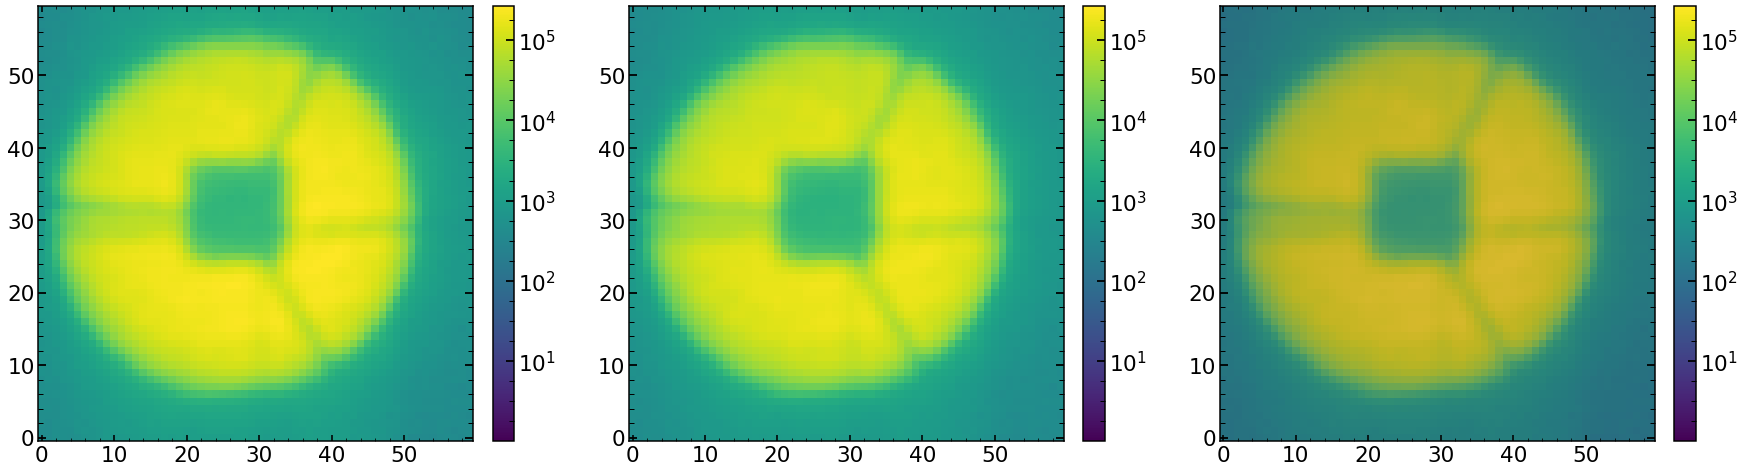

In [151]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [152]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain,like_min=single_analysis.create_likelihood()

(40, 390, 42) (196, 40, 42) (120, 390, 42) (252, 20, 42)
(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 646638.4766760694
minimal chi2 reduced is: 348.32200093114966


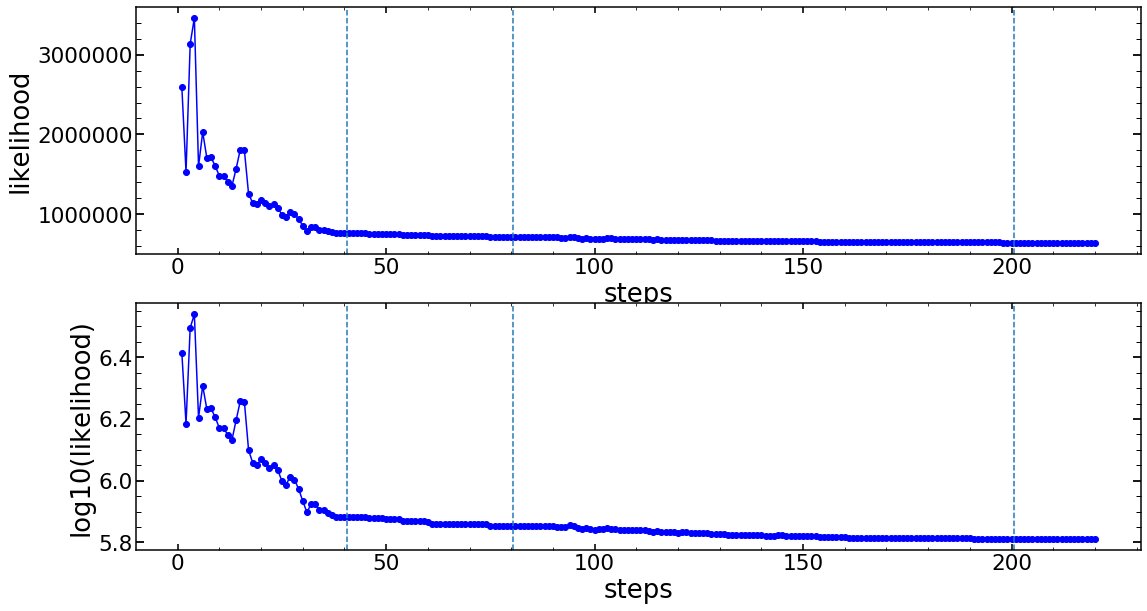

In [153]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(np.sum(len_of_chains[:1])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:2])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:3])+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(np.sum(len_of_chains[:1])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:2])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:3])+0.5,ls='--')

In [154]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=double_source,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (60, 60)
Top left pixel value of the science image is: 429.97003
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 434.28717
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [  -30.01746111    -0.52629957    -0.46009271     0.70172776
    -0.59577225    -0.07077737    -0.08996052    -0.18051933
     0.05692542     0.01595603     0.07939306     0.04273504
    -0.01451661    -0.02055206    -0.00399427    -0.02608453
    -0.01945134     0.0204636      0.07461322     0.65213602
     0.08034463     0.05675516    -0.10562142     0.05971529
     0.01888269     0.00001103     0.00001104     0.97272921
     0.94834497    -0.00018904    -0.03977849     0.93578652
     0.0901892      0.91200004     1.02539256 

-647127.2177485742

In [155]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')


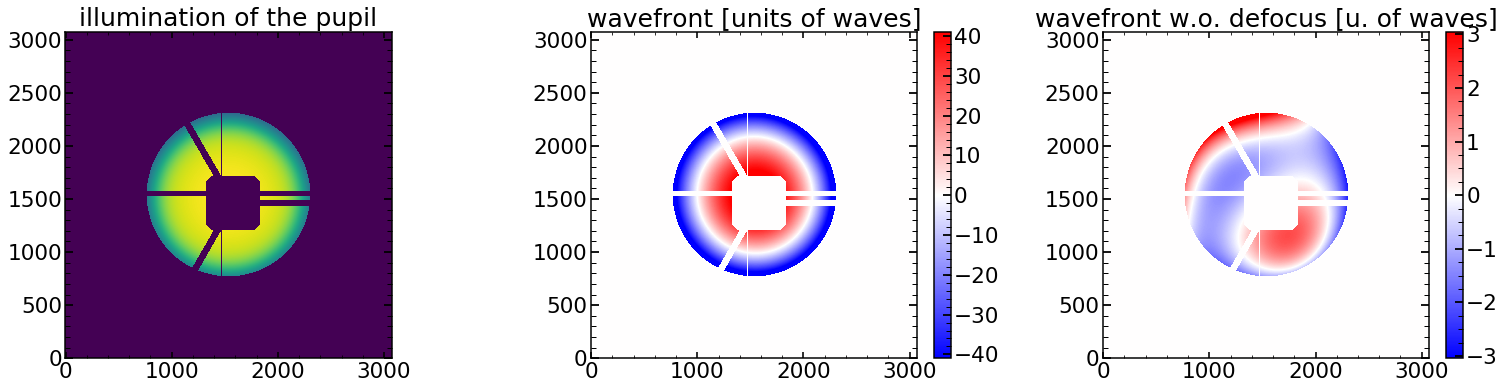

In [156]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 348.59352362947817
Abs of residual divided by total flux is: 0.054212652254144074
Abs of residual divided by largest value of a flux in the image is: 0.11531910712051678


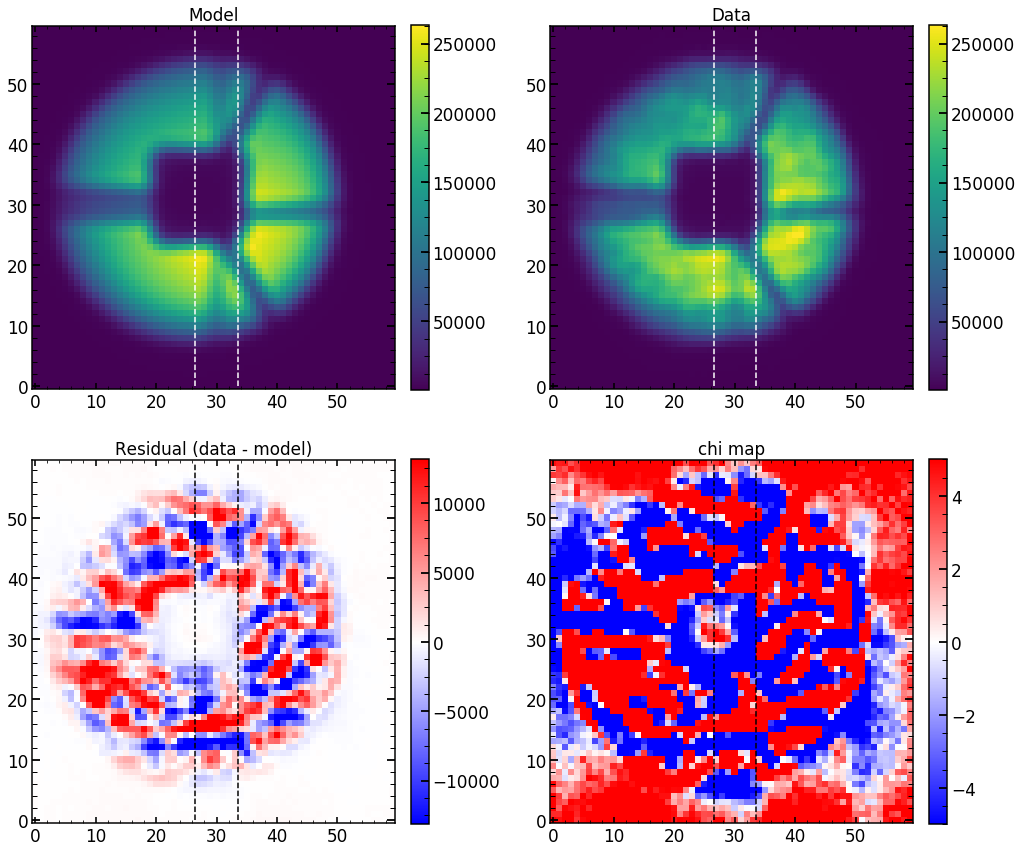

In [157]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

348.59352362947817
chi**2 reduced is: 348.59352362947817
Abs of residual divided by total flux is: 0.054212652254144074
Abs of residual divided by largest value of a flux in the image is: 0.11531910712051678


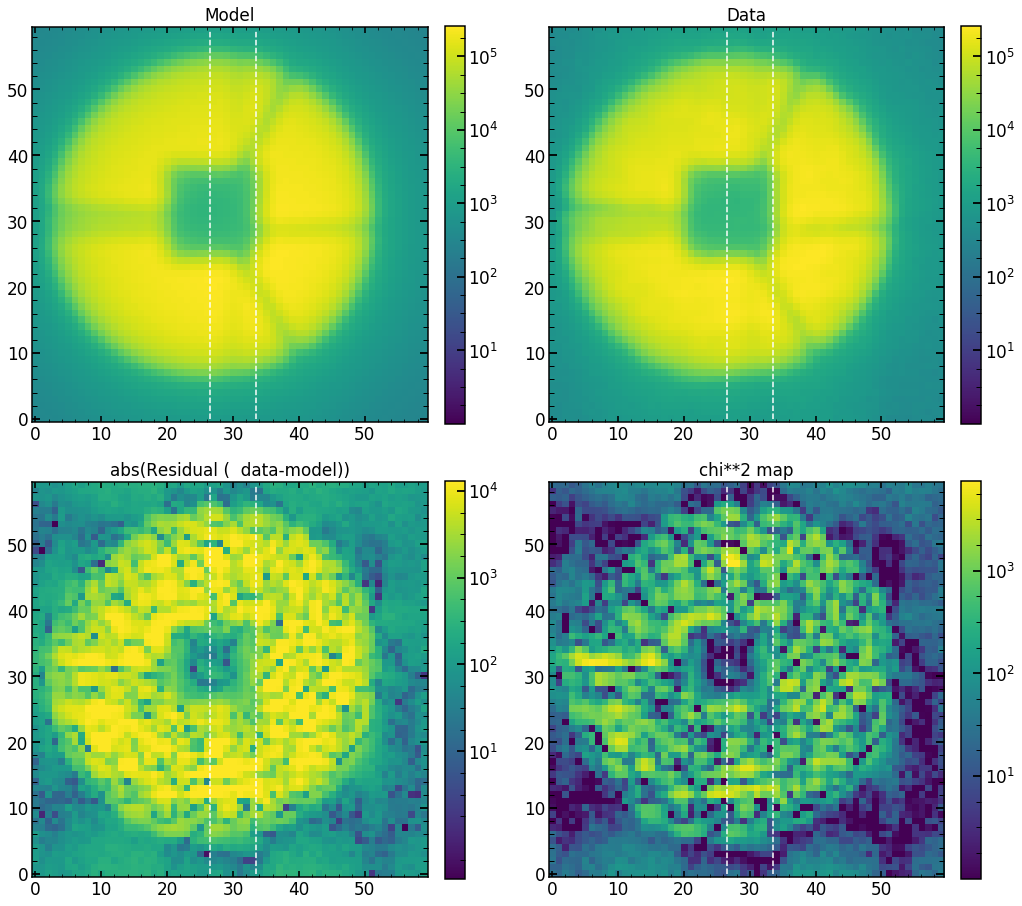

In [158]:
single_analysis.create_basic_comparison_plot_log()

348.59352362947817
chi**2 reduced is: 348.59352362947817
Abs of residual divided by total flux is: 0.054212652254144074
Abs of residual divided by largest value of a flux in the image is: 0.11531910712051678


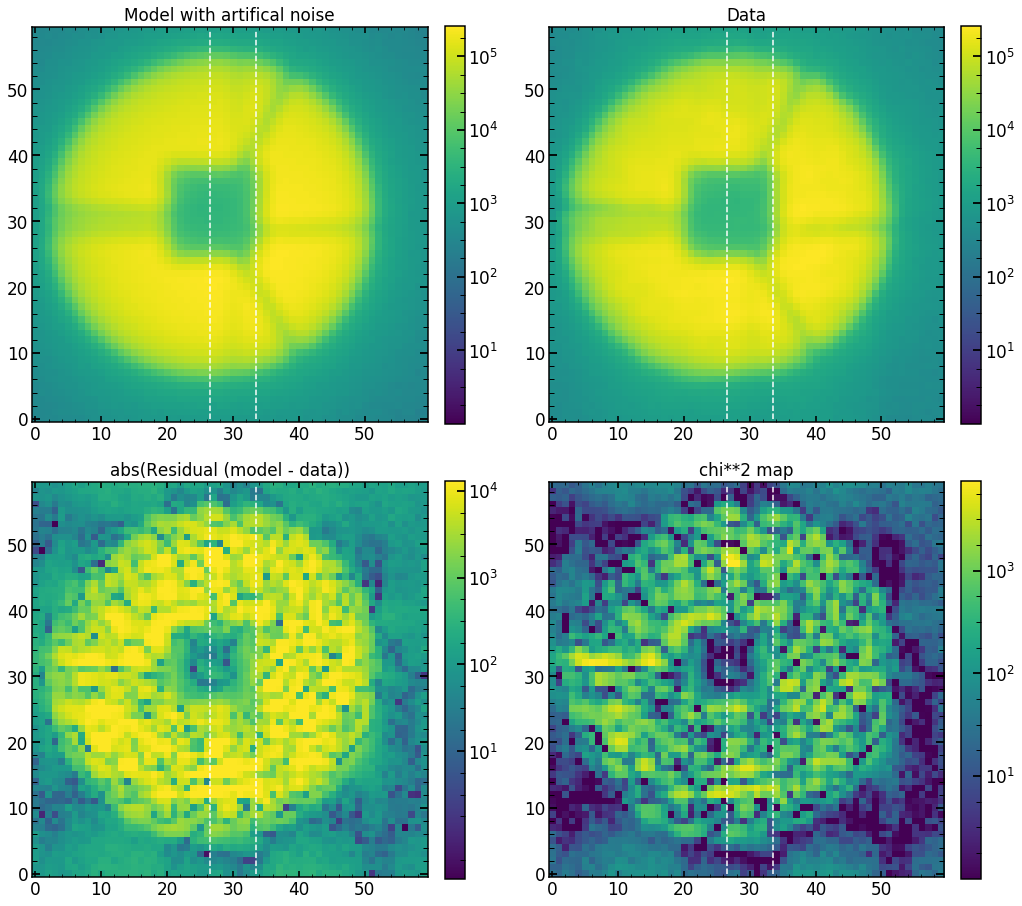

In [159]:
single_analysis.create_basic_comparison_plot_log_artifical()

## results everywhere 

In [197]:
unique_numbers_HgAr=np.unique(arranged_by_spot_number_HgAr[:,1])
unique_numbers_with_5_or_more_images_HgAr=[]
unique_numbers_with_4_or_less_images_HgAr=[]

unique_numbers_Ne=np.unique(arranged_by_spot_number_Ne[:,1])
unique_numbers_with_5_or_more_images_Ne=[]
unique_numbers_with_4_or_less_images_Ne=[]

unique_numbers_Kr=np.unique(arranged_by_spot_number_Kr[:,1])
unique_numbers_with_5_or_more_images_Kr=[]
unique_numbers_with_4_or_less_images_Kr=[]



for u in unique_numbers_HgAr:
    if np.sum(arranged_by_spot_number_HgAr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_HgAr.append(u)
    else:
        unique_numbers_with_4_or_less_images_HgAr.append(u)
        
        
for u in unique_numbers_Ne:
    if np.sum(arranged_by_spot_number_Ne[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Ne.append(u)
    else:
        unique_numbers_with_4_or_less_images_Ne.append(u)
        
    
for u in unique_numbers_Kr:
    if np.sum(arranged_by_spot_number_Kr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Kr.append(u)
    else:
        unique_numbers_with_4_or_less_images_Kr.append(u)

In [198]:
print(unique_numbers_with_5_or_more_images_HgAr)
print(unique_numbers_with_5_or_more_images_Ne) 
print(unique_numbers_with_5_or_more_images_Kr)
print('######')
print(unique_numbers_with_4_or_less_images_HgAr)
print(unique_numbers_with_4_or_less_images_Ne)
print(unique_numbers_with_4_or_less_images_Kr)

[1, 3, 6, 9, 11, 13, 15, 18, 21, 23, 25, 27, 30, 33, 35, 37, 39, 42, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 73, 75, 78, 81, 83, 85, 87, 90, 93, 95, 97, 99, 102, 105, 107, 109, 111, 114, 117, 119]
[2, 3, 5, 6, 8, 11, 12, 14, 15, 17, 20, 21, 23, 24, 26, 29, 30, 31, 32, 33, 35, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89]
[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38]
######
[51, 64, 71]
[0, 7, 9, 16, 18, 25, 27, 28, 34, 36, 43, 52, 61, 70, 79, 88]
[]


In [199]:
date='Mar0620'

results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalHgAr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                         index=finalHgAr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in unique_numbers_with_5_or_more_images_HgAr:
    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'HgAr',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,return_solution_at_05_0_05=None)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_HgAr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_HgAr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_HgAr[label[i]]=results_of_fit_many_HgAr[label[i]][np.abs(results_of_fit_many_HgAr[label[i]]['z4'])>0]

1 obs (Emcee3, defocus): 21352 (-4.0) is found!
1 obs (Emcee3, defocus): 21358 (-3.5) is found!
1 obs (Emcee3, defocus): 21364 (-3.0) is found!
1 obs (Emcee3, defocus): 21382 (-1.5) is found!
1 obs (Emcee3, defocus): 21400 (0) is found!
1 obs (Emcee3, defocus): 21400 (0) is found!
1 obs (Emcee3, defocus): 21406 (0.5) is found!
1 obs (Emcee3, defocus): 21418 (1.5) is found!
1 obs (Emcee3, defocus): 21436 (3.0) is found!
1 obs (Emcee3, defocus): 21442 (3.5) is found!
1 obs (Emcee3, defocus): 21448 (4) is found!
3 obs (Emcee3, defocus): 21352 (-4.0) is found!
3 obs (Emcee3, defocus): 21358 (-3.5) is found!
3 obs (Emcee3, defocus): 21364 (-3.0) is found!
3 obs (Emcee3, defocus): 21382 (-1.5) is found!
3 obs (Emcee3, defocus): 21400 (0) is found!
3 obs (Emcee3, defocus): 21400 (0) is found!
3 obs (Emcee3, defocus): 21406 (0.5) is found!
3 obs (Emcee3, defocus): 21418 (1.5) is found!
3 obs (Emcee3, defocus): 21436 (3.0) is found!
3 obs (Emcee3, defocus): 21442 (3.5) is found!
3 obs (Emcee3, 

39 obs (Emcee3, defocus): 21400 (0) is found!
39 obs (Emcee3, defocus): 21400 (0) is found!
39 obs (Emcee3, defocus): 21406 (0.5) is found!
39 obs (Emcee3, defocus): 21418 (1.5) is found!
39 obs (Emcee3, defocus): 21436 (3.0) is found!
39 obs (Emcee3, defocus): 21448 (4) is found!
42 obs (Emcee3, defocus): 21352 (-4.0) is found!
42 obs (Emcee3, defocus): 21358 (-3.5) is found!
42 obs (Emcee3, defocus): 21364 (-3.0) is found!
42 obs (Emcee3, defocus): 21382 (-1.5) is found!
42 obs (Emcee3, defocus): 21400 (0) is found!
42 obs (Emcee3, defocus): 21400 (0) is found!
42 obs (Emcee3, defocus): 21406 (0.5) is found!
42 obs (Emcee3, defocus): 21418 (1.5) is found!
42 obs (Emcee3, defocus): 21436 (3.0) is found!
42 obs (Emcee3, defocus): 21442 (3.5) is found!
42 obs (Emcee3, defocus): 21448 (4) is found!
45 obs (Emcee3, defocus): 21352 (-4.0) is found!
45 obs (Emcee3, defocus): 21358 (-3.5) is found!
45 obs (Emcee3, defocus): 21364 (-3.0) is found!
45 obs (Emcee3, defocus): 21382 (-1.5) is fou

59 obs (Emcee3, defocus): 21352 (-4.0) is found!
59 obs (Emcee3, defocus): 21358 (-3.5) is found!
59 obs (Emcee3, defocus): 21364 (-3.0) is found!
59 obs (Emcee3, defocus): 21382 (-1.5) is found!
59 obs (Emcee3, defocus): 21394 (-0.5) is found!
59 obs (Emcee3, defocus): 21400 (0) is found!
59 obs (Emcee3, defocus): 21400 (0) is found!
59 obs (Emcee3, defocus): 21406 (0.5) is found!
59 obs (Emcee3, defocus): 21418 (1.5) is found!
59 obs (Emcee3, defocus): 21436 (3.0) is found!
59 obs (Emcee3, defocus): 21442 (3.5) is found!
59 obs (Emcee3, defocus): 21448 (4) is found!
60 obs (Emcee3, defocus): 21352 (-4.0) is found!
60 obs (Emcee3, defocus): 21358 (-3.5) is found!
60 obs (Emcee3, defocus): 21394 (-0.5) is found!
60 obs (Emcee3, defocus): 21400 (0) is found!
60 obs (Emcee3, defocus): 21400 (0) is found!
60 obs (Emcee3, defocus): 21406 (0.5) is found!
60 obs (Emcee3, defocus): 21442 (3.5) is found!
60 obs (Emcee3, defocus): 21448 (4) is found!
61 obs (Emcee3, defocus): 21352 (-4.0) is fo

83 obs (Emcee3, defocus): 21436 (3.0) is found!
83 obs (Emcee3, defocus): 21442 (3.5) is found!
83 obs (Emcee3, defocus): 21448 (4) is found!
85 obs (Emcee3, defocus): 21352 (-4.0) is found!
85 obs (Emcee3, defocus): 21358 (-3.5) is found!
85 obs (Emcee3, defocus): 21364 (-3.0) is found!
85 obs (Emcee3, defocus): 21382 (-1.5) is found!
85 obs (Emcee3, defocus): 21400 (0) is found!
85 obs (Emcee3, defocus): 21400 (0) is found!
85 obs (Emcee3, defocus): 21406 (0.5) is found!
85 obs (Emcee3, defocus): 21418 (1.5) is found!
85 obs (Emcee3, defocus): 21436 (3.0) is found!
85 obs (Emcee3, defocus): 21442 (3.5) is found!
85 obs (Emcee3, defocus): 21448 (4) is found!
87 obs (Emcee3, defocus): 21352 (-4.0) is found!
87 obs (Emcee3, defocus): 21358 (-3.5) is found!
87 obs (Emcee3, defocus): 21364 (-3.0) is found!
87 obs (Emcee3, defocus): 21382 (-1.5) is found!
87 obs (Emcee3, defocus): 21400 (0) is found!
87 obs (Emcee3, defocus): 21400 (0) is found!
87 obs (Emcee3, defocus): 21406 (0.5) is fou

In [200]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)


results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

for single_number in unique_numbers_with_5_or_more_images_Ne:

    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,return_solution_at_05_0_05=None)    
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Ne[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Ne[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]

2 obs (Emcee3, defocus): 21556 (-4.0) is found!
2 obs (Emcee3, defocus): 21562 (-3.5) is found!
2 obs (Emcee3, defocus): 21568 (-3.0) is found!
2 obs (Emcee3, defocus): 21574 (-2.5) is found!
2 obs (Emcee3, defocus): 21586 (-1.5) is found!
2 obs (Emcee3, defocus): 21598 (-0.5) is found!
2 obs (Emcee3, defocus): 21604 (0) is found!
2 obs (Emcee3, defocus): 21604 (0) is found!
2 obs (Emcee3, defocus): 21610 (0.5) is found!
2 obs (Emcee3, defocus): 21622 (1.5) is found!
2 obs (Emcee3, defocus): 21634 (2.5) is found!
2 obs (Emcee3, defocus): 21640 (3.0) is found!
2 obs (Emcee3, defocus): 21646 (3.5) is found!
2 obs (Emcee3, defocus): 21652 (4) is found!
3 obs (Emcee3, defocus): 21556 (-4.0) is found!
3 obs (Emcee3, defocus): 21562 (-3.5) is found!
3 obs (Emcee3, defocus): 21568 (-3.0) is found!
3 obs (Emcee3, defocus): 21586 (-1.5) is found!
3 obs (Emcee3, defocus): 21598 (-0.5) is found!
3 obs (Emcee3, defocus): 21604 (0) is found!
3 obs (Emcee3, defocus): 21604 (0) is found!
3 obs (Emcee

26 obs (Emcee3, defocus): 21610 (0.5) is found!
26 obs (Emcee3, defocus): 21646 (3.5) is found!
26 obs (Emcee3, defocus): 21652 (4) is found!
29 obs (Emcee3, defocus): 21556 (-4.0) is found!
29 obs (Emcee3, defocus): 21562 (-3.5) is found!
29 obs (Emcee3, defocus): 21568 (-3.0) is found!
29 obs (Emcee3, defocus): 21574 (-2.5) is found!
29 obs (Emcee3, defocus): 21586 (-1.5) is found!
29 obs (Emcee3, defocus): 21598 (-0.5) is found!
29 obs (Emcee3, defocus): 21604 (0) is found!
29 obs (Emcee3, defocus): 21604 (0) is found!
29 obs (Emcee3, defocus): 21610 (0.5) is found!
29 obs (Emcee3, defocus): 21622 (1.5) is found!
29 obs (Emcee3, defocus): 21634 (2.5) is found!
29 obs (Emcee3, defocus): 21640 (3.0) is found!
29 obs (Emcee3, defocus): 21646 (3.5) is found!
29 obs (Emcee3, defocus): 21652 (4) is found!
30 obs (Emcee3, defocus): 21598 (-0.5) is found!
30 obs (Emcee3, defocus): 21604 (0) is found!
30 obs (Emcee3, defocus): 21604 (0) is found!
30 obs (Emcee3, defocus): 21610 (0.5) is foun

51 obs (Emcee3, defocus): 21556 (-4.0) is found!
51 obs (Emcee3, defocus): 21562 (-3.5) is found!
51 obs (Emcee3, defocus): 21568 (-3.0) is found!
51 obs (Emcee3, defocus): 21574 (-2.5) is found!
51 obs (Emcee3, defocus): 21586 (-1.5) is found!
51 obs (Emcee3, defocus): 21598 (-0.5) is found!
51 obs (Emcee3, defocus): 21604 (0) is found!
51 obs (Emcee3, defocus): 21604 (0) is found!
51 obs (Emcee3, defocus): 21610 (0.5) is found!
51 obs (Emcee3, defocus): 21622 (1.5) is found!
51 obs (Emcee3, defocus): 21634 (2.5) is found!
51 obs (Emcee3, defocus): 21640 (3.0) is found!
51 obs (Emcee3, defocus): 21646 (3.5) is found!
51 obs (Emcee3, defocus): 21652 (4) is found!
53 obs (Emcee3, defocus): 21556 (-4.0) is found!
53 obs (Emcee3, defocus): 21562 (-3.5) is found!
53 obs (Emcee3, defocus): 21568 (-3.0) is found!
53 obs (Emcee3, defocus): 21574 (-2.5) is found!
53 obs (Emcee3, defocus): 21586 (-1.5) is found!
53 obs (Emcee3, defocus): 21598 (-0.5) is found!
53 obs (Emcee3, defocus): 21604 (0

72 obs (Emcee3, defocus): 21610 (0.5) is found!
72 obs (Emcee3, defocus): 21634 (2.5) is found!
72 obs (Emcee3, defocus): 21640 (3.0) is found!
72 obs (Emcee3, defocus): 21646 (3.5) is found!
72 obs (Emcee3, defocus): 21652 (4) is found!
74 obs (Emcee3, defocus): 21556 (-4.0) is found!
74 obs (Emcee3, defocus): 21562 (-3.5) is found!
74 obs (Emcee3, defocus): 21568 (-3.0) is found!
74 obs (Emcee3, defocus): 21574 (-2.5) is found!
74 obs (Emcee3, defocus): 21586 (-1.5) is found!
74 obs (Emcee3, defocus): 21598 (-0.5) is found!
74 obs (Emcee3, defocus): 21604 (0) is found!
74 obs (Emcee3, defocus): 21604 (0) is found!
74 obs (Emcee3, defocus): 21610 (0.5) is found!
74 obs (Emcee3, defocus): 21622 (1.5) is found!
74 obs (Emcee3, defocus): 21634 (2.5) is found!
74 obs (Emcee3, defocus): 21640 (3.0) is found!
74 obs (Emcee3, defocus): 21646 (3.5) is found!
74 obs (Emcee3, defocus): 21652 (4) is found!
75 obs (Emcee3, defocus): 21556 (-4.0) is found!
75 obs (Emcee3, defocus): 21562 (-3.5) is

In [201]:
results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(results_of_fit_many_single_defocus_Kr)
err_results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Kr)


results_of_fit_many_Kr = {'m4': results_of_fit_many_single_defocus_Kr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Kr_pd.copy()}

for single_number in unique_numbers_with_5_or_more_images_Kr:
        
    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'Kr',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,return_solution_at_05_0_05=None)   
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Kr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Kr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Kr[label[i]]=results_of_fit_many_Kr[label[i]][np.abs(results_of_fit_many_Kr[label[i]]['z4'])>0]

0 obs (Emcee3, defocus): 21760 (-4.0) is found!
0 obs (Emcee3, defocus): 21766 (-3.5) is found!
0 obs (Emcee3, defocus): 21772 (-3.0) is found!
0 obs (Emcee3, defocus): 21778 (-2.5) is found!
0 obs (Emcee3, defocus): 21790 (-1.5) is found!
0 obs (Emcee3, defocus): 21808 (0) is found!
0 obs (Emcee3, defocus): 21808 (0) is found!
0 obs (Emcee3, defocus): 21814 (0.5) is found!
0 obs (Emcee3, defocus): 21826 (1.5) is found!
0 obs (Emcee3, defocus): 21838 (2.5) is found!
0 obs (Emcee3, defocus): 21844 (3.0) is found!
0 obs (Emcee3, defocus): 21850 (3.5) is found!
0 obs (Emcee3, defocus): 21856 (4) is found!
1 obs (Emcee3, defocus): 21760 (-4.0) is found!
1 obs (Emcee3, defocus): 21766 (-3.5) is found!
1 obs (Emcee3, defocus): 21772 (-3.0) is found!
1 obs (Emcee3, defocus): 21778 (-2.5) is found!
1 obs (Emcee3, defocus): 21790 (-1.5) is found!
1 obs (Emcee3, defocus): 21802 (-0.5) is found!
1 obs (Emcee3, defocus): 21808 (0) is found!
1 obs (Emcee3, defocus): 21808 (0) is found!
1 obs (Emcee

17 obs (Emcee3, defocus): 21790 (-1.5) is found!
17 obs (Emcee3, defocus): 21808 (0) is found!
17 obs (Emcee3, defocus): 21808 (0) is found!
17 obs (Emcee3, defocus): 21814 (0.5) is found!
17 obs (Emcee3, defocus): 21826 (1.5) is found!
17 obs (Emcee3, defocus): 21844 (3.0) is found!
17 obs (Emcee3, defocus): 21856 (4) is found!
18 obs (Emcee3, defocus): 21760 (-4.0) is found!
18 obs (Emcee3, defocus): 21772 (-3.0) is found!
18 obs (Emcee3, defocus): 21790 (-1.5) is found!
18 obs (Emcee3, defocus): 21808 (0) is found!
18 obs (Emcee3, defocus): 21808 (0) is found!
18 obs (Emcee3, defocus): 21814 (0.5) is found!
18 obs (Emcee3, defocus): 21826 (1.5) is found!
18 obs (Emcee3, defocus): 21844 (3.0) is found!
18 obs (Emcee3, defocus): 21856 (4) is found!
19 obs (Emcee3, defocus): 21760 (-4.0) is found!
19 obs (Emcee3, defocus): 21766 (-3.5) is found!
19 obs (Emcee3, defocus): 21772 (-3.0) is found!
19 obs (Emcee3, defocus): 21790 (-1.5) is found!
19 obs (Emcee3, defocus): 21808 (0) is found

33 obs (Emcee3, defocus): 21772 (-3.0) is found!
33 obs (Emcee3, defocus): 21778 (-2.5) is found!
33 obs (Emcee3, defocus): 21790 (-1.5) is found!
33 obs (Emcee3, defocus): 21808 (0) is found!
33 obs (Emcee3, defocus): 21808 (0) is found!
33 obs (Emcee3, defocus): 21814 (0.5) is found!
33 obs (Emcee3, defocus): 21826 (1.5) is found!
33 obs (Emcee3, defocus): 21838 (2.5) is found!
33 obs (Emcee3, defocus): 21844 (3.0) is found!
33 obs (Emcee3, defocus): 21850 (3.5) is found!
33 obs (Emcee3, defocus): 21856 (4) is found!
34 obs (Emcee3, defocus): 21760 (-4.0) is found!
34 obs (Emcee3, defocus): 21766 (-3.5) is found!
34 obs (Emcee3, defocus): 21772 (-3.0) is found!
34 obs (Emcee3, defocus): 21778 (-2.5) is found!
34 obs (Emcee3, defocus): 21790 (-1.5) is found!
34 obs (Emcee3, defocus): 21802 (-0.5) is found!
34 obs (Emcee3, defocus): 21808 (0) is found!
34 obs (Emcee3, defocus): 21808 (0) is found!
34 obs (Emcee3, defocus): 21814 (0.5) is found!
34 obs (Emcee3, defocus): 21826 (1.5) is 

In [202]:
labels_with_data_HgAr=[]
for i in range(len(label[:])):
    if len(results_of_fit_many_HgAr[label[i]])>5:
        labels_with_data_HgAr.append(i)
        
labels_with_data_Ne=[]
for i in range(len(label[:])):
    if len(results_of_fit_many_Ne[label[i]])>5:
        labels_with_data_Ne.append(i)
   
labels_with_data_Kr=[]
for i in range(len(label[:])):
    if len(results_of_fit_many_Kr[label[i]])>5:
        labels_with_data_Kr.append(i)

labels_with_data=np.unique(labels_with_data_HgAr+labels_with_data_Ne+labels_with_data_Kr)

In [203]:
pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)

In [204]:
# plot the results of the interpolation
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Mar0620'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed

for j in tqdm(labels_with_data):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # take values for Krypton        
        x_Kr=finalKr.loc[results_of_fit_many_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Kr=finalKr.loc[results_of_fit_many_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Kr=np.array(results_of_fit_many_Kr[label[j]][descriptions[i]])        
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne,x_Kr))
        y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
        colors= np.concatenate((values_HgAr,values_Ne,values_Kr))
        

        
        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 
                    
            # limits of color for z12-z22
            if np.in1d([i],[8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=0.25
                    min_colors=-0.25

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(np.quantile(colors,0.9)-median_color)
                low_limit=np.abs(np.quantile(colors,0.1)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1  

        plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='o')
        plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='s')
        plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='p')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+': '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 15/15 [05:33<00:00, 22.24s/it]


<Figure size 864x720 with 0 Axes>

# Faster create_result()

In [35]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)


results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

for single_number in unique_numbers_with_5_or_more_images_Ne[5:6]:

    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=True,return_solution_at_05_0_05=None)    
    

            
#for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
#    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]

12 obs (Emcee3, defocus): 21556 is found!
12 obs (Emcee3, defocus): 21568 is found!
12 obs (Emcee3, defocus): 21586 is found!
12 obs (Emcee3, defocus): 21598 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee2, defocus): 21610 is found!
12 obs (Emcee2, defocus): 21622 is found!
12 obs (Emcee3, defocus): 21640 is found!
12 obs (Emcee3, defocus): 21646 is found!
12 obs (Emcee3, defocus): 21652 is found!
12 obs (Emcee3, defocus): 21604 is found!


In [45]:
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    %prun results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()

12 obs (Emcee3, defocus): 21556 is found!
12 obs (Emcee3, defocus): 21568 is found!
12 obs (Emcee3, defocus): 21586 is found!
12 obs (Emcee3, defocus): 21598 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee2, defocus): 21610 is found!
12 obs (Emcee2, defocus): 21622 is found!
12 obs (Emcee3, defocus): 21640 is found!
12 obs (Emcee3, defocus): 21646 is found!
12 obs (Emcee3, defocus): 21652 is found!
12 obs (Emcee3, defocus): 21604 is found!
 

In [96]:
solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                      err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=None)

Empty DataFrame
Columns: [z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20, z21, z22, hscFrac, strutFrac, dxFocal, dyFocal, slitFrac, slitFrac_dy, radiometricEffect, radiometricExponent, x_ilum, y_ilum, x_fiber, y_fiber, effective_radius_illumination, frd_sigma, frd_lorentz_factor, det_vert, slitHolder_frac_dx, grating_lines, scattering_slope, scattering_amplitude, pixel_effect, fiber_r, flux, chi2, chi2max]
Index: []

[0 rows x 44 columns]
0


In [92]:
results_of_fit_single

,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,...,det_vert,slitHolder_frac_dx,grating_lines,scattering_slope,scattering_amplitude,pixel_effect,fiber_r,flux,chi2,chi2max
-4.0,30.889953,-0.782896,-0.380881,0.557414,0.284642,-0.084343,-0.306468,-0.216152,-0.171049,-0.061664,...,0.991876,0.525868,96628.201844,2.401770,0.004114,0.372592,1.839658,0.995476,436.545402,87088.906250
-3.5,27.196036,-0.638222,-0.287460,0.554352,0.291296,-0.088280,-0.340491,-0.217878,-0.178047,-0.070563,...,1.008408,0.518896,94507.119689,2.188352,0.001853,0.372592,1.839658,0.994819,429.804113,96481.718750
-3.0,22.999411,-0.397099,-0.238579,0.488047,0.289071,-0.031435,-0.259940,-0.279464,-0.167414,-0.076414,...,0.984736,0.532994,100528.726320,2.163521,0.001614,0.372592,1.839658,1.002576,415.949897,115032.296875
-2.5,19.560455,-0.218395,-0.279414,0.481649,0.230988,-0.033748,-0.327135,-0.266683,-0.164985,-0.082541,...,0.993655,0.496347,111013.702104,2.433925,0.003749,0.372592,1.839658,0.997784,384.728242,151428.015625
-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-1.5,11.810266,-0.006752,-0.150153,0.410283,0.327476,-0.014559,-0.295522,-0.236938,-0.164145,-0.099247,...,1.007921,0.535437,100321.635293,2.367024,0.003339,0.372592,1.839658,0.997595,149.699183,97960.140625
-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
        results_of_fit_single_near_focus=results_of_fit_single[int(len(results_of_fit_single)/2)-2:int(len(results_of_fit_single)/2)+2]    
        results_of_fit_single_near_focus=results_of_fit_single_near_focus[np.abs(results_of_fit_single_near_focus['z4'])>0]
        
        print(len(results_of_fit_single_near_focus))

0


In [42]:
%prun result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                      err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=None)

In [ ]:
    def create_minchain_err(self,chain0,likechain0,sci_image,var_image,old=0):
        """create error on the parameters from the chains
        @param chain0      
        @param likechain0  
        @param sci_image  
        @param var_image  
        @param old 
        
        @returns        
        """
        columns22=self.columns22
        columns11=self.columns11

        minchain_err_test=[]
        if len(chain0[0][0])==42:
            columns=columns22          
        else:
            columns=columns11


        for var_number in range(len(columns)):
            #ravel likelihood
            likechain0_Emcee3_ravel=np.ravel(likechain0)
    
            # connect chain and lnchain
            chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
            chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
            chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
            likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
    
            # move to chi2 space
            # you should take into account mask!
            chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
            min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)
    
            # simplest standard deviation
            std_chain=np.std(chain0_Emcee3_ravel_sort)
    
            #best solution
            mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]
    
            # step size
            step=std_chain/10
            
            # if standard deviation is much much smaller than the mean value aborth the effort
            # and set the erros to be equal to the mean value
            # if the standard deviation is so small it means that there were problems in the fit
            # or you intentionally did not move the variable
            if std_chain<np.abs(mean_chain)/10**6:
                minchain_err_element=[-mean_chain,mean_chain]
            else:
                # create result, go 3*std in each direction
                try:
                    res=[]
                    for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                        selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                        if len(selected_chi2_Emcee3_ravel_sort>10):   
                            res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])
        
                    res=np.array(res)
        
                    #print(columns[var_number]+' min : '+str(mean_chain))
                    #print(columns[var_number]+' std : '+str(std_chain))
        
                    # find low limit and high limit
                    res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
                    minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
                except IndexError:   
                    if self.verbosity==1:
                        print(columns[var_number]+': failed!')
                    minchain_err_element=[-mean_chain,mean_chain]
    
            minchain_err_test.append(minchain_err_element)
            #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
            #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
        if old==1:
            minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
            #print(minchain_err_test)
            return minchain_err_test
        else:       
            return np.array(minchain_err_test)

# Higher order Zernike 

In [ ]:
# create module or function that takes images and lower level and wanted order to get the result 

In [171]:
final_optpsf_image=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/final_optpsf_image21652565Ne.npy')

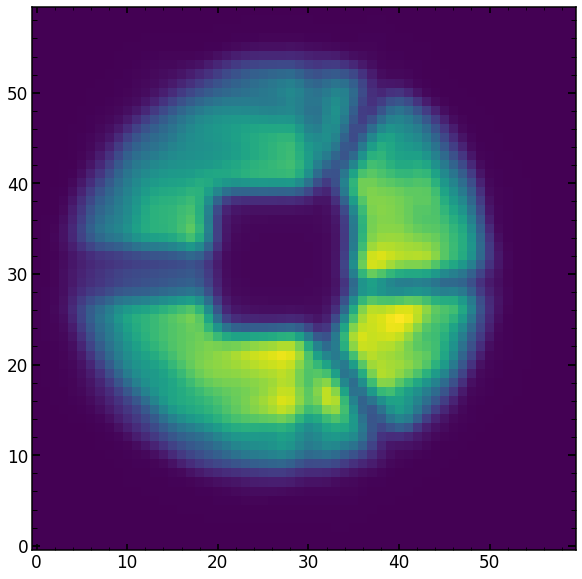

In [172]:
plt.imshow(final_optpsf_image)

chi**2 reduced is: 219.18413403234092
Abs of residual divided by total flux is: 0.03341803310967147
Abs of residual divided by largest value of a flux in the image is: 0.06623103625122362


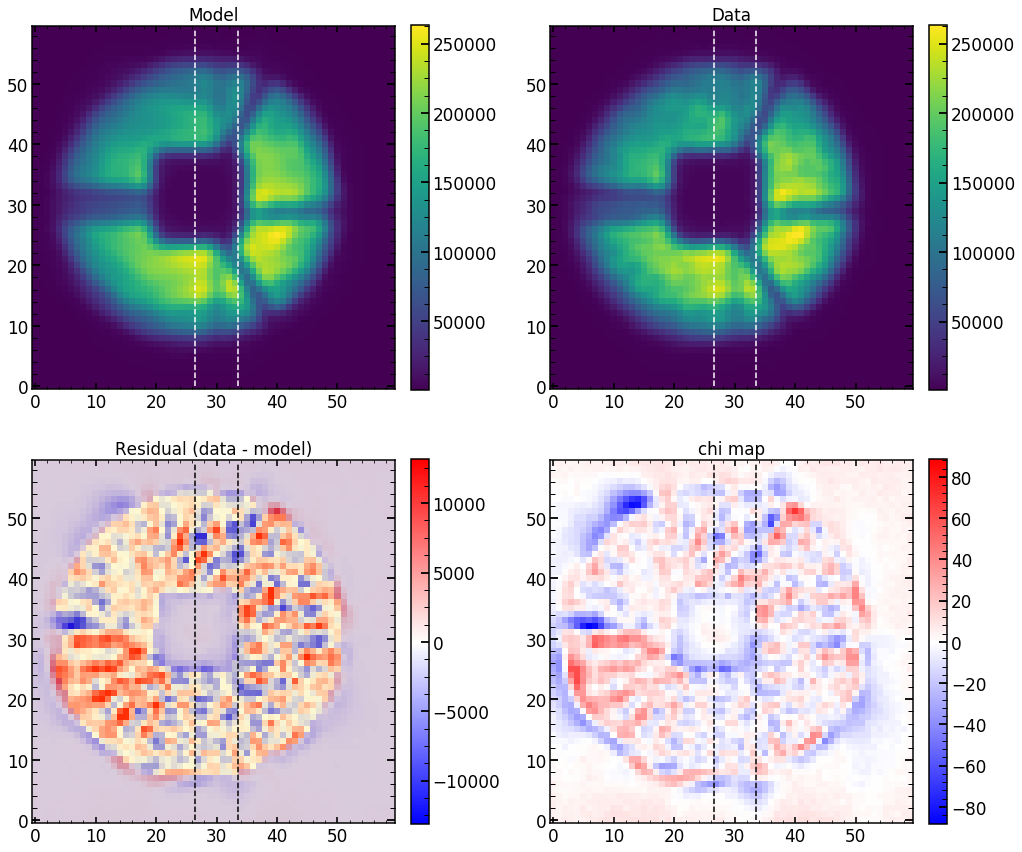

In [185]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_image=final_optpsf_image,custom_mask=mask,use_max_chi_scaling=True)

# Scripts making

In [ ]:
# which ones are avaliable from Mar06 & have no overlap

In [217]:
HgAr_p4_and_only_one=np.intersect1d(results_of_fit_many_HgAr['p4'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_p35_and_only_one=np.intersect1d(results_of_fit_many_HgAr['p35'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_p3_and_only_one=np.intersect1d(results_of_fit_many_HgAr['p3'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_m4_and_only_one=np.intersect1d(results_of_fit_many_HgAr['m4'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_m35_and_only_one=np.intersect1d(results_of_fit_many_HgAr['m35'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_m3_and_only_one=np.intersect1d(results_of_fit_many_HgAr['m3'].index,finalHgAr[finalHgAr['close']=='1'].index)

Ne_p4_and_only_one=np.intersect1d(results_of_fit_many_Ne['p4'].index,finalNe[finalNe['close']=='1'].index)
Ne_p35_and_only_one=np.intersect1d(results_of_fit_many_Ne['p35'].index,finalNe[finalNe['close']=='1'].index)
Ne_p3_and_only_one=np.intersect1d(results_of_fit_many_Ne['p3'].index,finalNe[finalNe['close']=='1'].index)
Ne_m4_and_only_one=np.intersect1d(results_of_fit_many_Ne['m4'].index,finalNe[finalNe['close']=='1'].index)
Ne_m35_and_only_one=np.intersect1d(results_of_fit_many_Ne['m35'].index,finalNe[finalNe['close']=='1'].index)
Ne_m3_and_only_one=np.intersect1d(results_of_fit_many_Ne['m3'].index,finalNe[finalNe['close']=='1'].index)

Kr_p4_and_only_one=np.intersect1d(results_of_fit_many_Kr['p4'].index,finalKr[finalKr['close']=='1'].index)
Kr_p35_and_only_one=np.intersect1d(results_of_fit_many_Kr['p35'].index,finalKr[finalKr['close']=='1'].index)
Kr_p3_and_only_one=np.intersect1d(results_of_fit_many_Kr['p3'].index,finalKr[finalKr['close']=='1'].index)
Kr_m4_and_only_one=np.intersect1d(results_of_fit_many_Kr['m4'].index,finalKr[finalKr['close']=='1'].index)
Kr_m35_and_only_one=np.intersect1d(results_of_fit_many_Kr['m35'].index,finalKr[finalKr['close']=='1'].index)
Kr_m3_and_only_one=np.intersect1d(results_of_fit_many_Kr['m3'].index,finalKr[finalKr['close']=='1'].index)

In [222]:
'python /home/ncaplar/Code/Zernike_parameter_estimation.py 21646 56 2 5 4 Ne 0 [0,0] 254 Mar06 direct Mar07'

array([], dtype=int64)

In [232]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_p4_Apr2.sh','w') 
for single_spot in HgAr_p4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21448 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 \n")
    
file.close()    
  
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_p35_Apr2.sh','w') 
for single_spot in HgAr_p35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21442 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_p2_Apr2.sh','w') 
for single_spot in HgAr_p3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21436 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_m4_Apr2.sh','w') 
for single_spot in HgAr_m4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21352 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_m35_Apr2.sh','w') 
for single_spot in HgAr_m35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21358 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_m3_Apr2.sh','w') 
for single_spot in HgAr_m3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21364 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  


file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_p4_Apr2.sh','w') 
for single_spot in Ne_p4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21652 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_p35_Apr2.sh','w') 
for single_spot in Ne_p35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21648 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_p3_Apr2.sh','w') 
for single_spot in Ne_p3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21642 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_m4_Apr2.sh','w') 
for single_spot in Ne_m4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21556 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_m35_Apr2.sh','w') 
for single_spot in Ne_m35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21562 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_m3_Apr2.sh','w') 
for single_spot in Ne_m3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21568 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr02 \n")
file.close()  
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Apr2ScriptToSubmitScriptsTiger1'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for arc in ['HgAr','Ne']:
    for defocus in ['p4','p35','p3','m3','m35','m4']:
        file.write('sh /home/ncaplar/Scripts/'+str(arc)+'_'+str(defocus)+'_Apr2.sh \n')
file.close()

In [223]:
21346+102

21448

In [ ]:
/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/